In [8]:
import numpy as np
import scipy.optimize, scipy.constants
import matplotlib.pyplot as plt
import matplotlib as mpl

from PyNEC import *
from antenna_util import *

from context_clean import *

import math

brass_conductivity = 15600000 # mhos
copper_conductivity = 1.45e7 # Copper
ground_conductivity = 0.002
ground_dielectric = 10

start = 100
stop  = 150
count = stop - start

system_impedance = 50

design_freq_mhz = 143.05 # Currier frequency of GRAVES radar 
#design_freq_mhz = 113.0 # Center frequency of VOR beacons band 

wavelength = scipy.constants.c / (design_freq_mhz*1000000)


In [9]:
def n_seg(freq, length):
  wavelength = 3e8/(1e6*freq)
  return (2 * (int(math.ceil(77*length/wavelength))/2)) + 1



def sc_quad_helix(height, diameter, wire_diameter = 0.02):
    
    nec = context_clean(nec_context())
    nec.set_extended_thin_wire_kernel(True)
    
    geo = geometry_clean(nec.get_geometry())

    wire_r = wire_diameter/2;
    helix_r = diameter/2;
    
    
    #print "Wire Diameter %s" % (wire_r * 2)
    
    helix_turns = 0.5
    helix_elevation = 0.1  # elevation of helix above conductive plate
    excitation_lenght = 0.1
    
    # helix loop 
    helix_twist_height = height / helix_turns
    geo.wire(tag_id=1, nr_segments=1, src=np.array([helix_r, 0, 0]), dst=np.array([helix_r, 0, -excitation_lenght]), radius=wire_r)
    geo.helix(tag_id=1, nr_segments=50, spacing=helix_twist_height, lenght=height, start_radius=np.array([helix_r, helix_r]), end_radius=np.array([helix_r, helix_r]), wire_radius=wire_r)
    geo.move(rotate_z=90, move_z=0, copies=3, segment=0, tag_inc=1)
    geo.wire(tag_id=10, nr_segments=2, src=np.array([0, 0, height]), dst=np.array([helix_r, 0, height]), radius=wire_r)
    geo.wire(tag_id=11, nr_segments=2, src=np.array([0, 0, height]), dst=np.array([0, helix_r, height]), radius=wire_r)
    geo.wire(tag_id=12, nr_segments=2, src=np.array([0, 0, height]), dst=np.array([-helix_r, 0, height]), radius=wire_r)
    geo.wire(tag_id=13, nr_segments=2, src=np.array([0, 0, height]), dst=np.array([0, -helix_r, height]), radius=wire_r)
    
    ## bottom helix connecting wires
    geo.wire(tag_id=20, nr_segments=2, src=np.array([0, 0, -excitation_lenght]), dst=np.array([helix_r, 0, -excitation_lenght]), radius=wire_r)
    geo.wire(tag_id=21, nr_segments=2, src=np.array([0, 0, -excitation_lenght]), dst=np.array([0, helix_r, -excitation_lenght]), radius=wire_r)
    geo.wire(tag_id=22, nr_segments=2, src=np.array([0, 0, -excitation_lenght]), dst=np.array([-helix_r, 0, -excitation_lenght]), radius=wire_r)
    geo.wire(tag_id=23, nr_segments=2, src=np.array([0, 0, -excitation_lenght]), dst=np.array([0, -helix_r, -excitation_lenght]), radius=wire_r)
    
    geo.wire(tag_id=1, nr_segments=1, src=np.array([0, 0, -excitation_lenght]), dst=np.array([0, 0, -helix_elevation -excitation_lenght]), radius=wire_r) # vertical wire connecting the patch and helixal antenna
    geo.rectangular_patch(a1 = np.array([-1, -1, -helix_elevation - excitation_lenght]), a2 = np.array([1, -1, -helix_elevation - excitation_lenght]), a3= np.array([1, 1, -helix_elevation - excitation_lenght]))
    #geo.rectangular_patch(a1 = np.array([-1, -1, 0]), a2 = np.array([1, -1, 0]), a3= np.array([1, 1, 0]))
    ## small patch
    #geo.rectangular_patch(a1 = np.array([-0.5, -0.5, -helix_elevation - excitation_lenght]), a2 = np.array([0.5, -0.5, -helix_elevation - excitation_lenght]), a3= np.array([0.5, 0.5, -helix_elevation - excitation_lenght]))

    # Everything is copper
    nec.set_wire_conductivity(copper_conductivity)
    # finish structure definition
    nec.geometry_complete(ground_plane=False)

    # Voltage excitation at legs of the antenna
    nec.voltage_excitation(wire_tag=1, segment_nr=1, voltage=1.0)
    nec.voltage_excitation(wire_tag=2, segment_nr=1, voltage=0.0+1.0j)
    nec.voltage_excitation(wire_tag=3, segment_nr=1, voltage=-1.0)
    nec.voltage_excitation(wire_tag=4, segment_nr=1, voltage=0.0-1.0j)
    #nec.set_frequencies_linear(start_frequency=140, stop_frequency=150, count=100)
    #nec.radiation_pattern(thetas=Range(90, 90, count=1), phis=Range(180,180,count=1))

    return nec

In [10]:
def get_gain_swr_range(height, diameter, wire_diameter, start=start, stop=stop, step=1):
    gains_db = []
    frequencies = []
    vswrs = []
    for freq in range(start, stop + 1, step):
        nec = sc_quad_helix(height, diameter, wire_diameter)
        nec.set_frequency(freq) # TODO: ensure that we don't need to re-generate this!
        nec.radiation_pattern(thetas=Range(0, 0, count=1), phis=Range(45,45,count=1))

        rp = nec.context.get_radiation_pattern(0)
        ipt = nec.get_input_parameters(0)
        z = ipt.get_impedance()[0]

        # Gains are in decibels
        gains_db.append(rp.get_gain()[0])
        vswrs.append(vswr(z, system_impedance))
        frequencies.append(ipt.get_frequency())

    return frequencies, gains_db, vswrs

def get_gain_swr(height, diameter, wire_diameter, freq):
    nec = sc_quad_helix(height, diameter, wire_diameter)
    nec.set_frequency(freq) # TODO: ensure that we don't need to re-generate this!
    nec.radiation_pattern(thetas=Range(0, 0, count=1), phis=Range(-90,90,count=90))

    rp = nec.context.get_radiation_pattern(0)
    ipt = nec.get_input_parameters(0)
    z = ipt.get_impedance()[0]
    
    gains_db = rp.get_gain() # Is an array of theta,phi -> gain. In this case we only have one phi    
    gain = np.average(gains_db[0,:])

    return ipt.get_frequency(), gain, vswr(z, system_impedance)

In [11]:
def create_optimization_target():
    def target(args):
        height, diameter, wire_diameter  = args
        if height <= 0 or diameter <= 0:
            print "wrong element dimension"
            return float('inf')

        try:
            result = 0.0

            vswr_score = 0.0
            gains_score = 0.0

            freq, gain, vswr = get_gain_swr(height, diameter, wire_diameter,  freq=design_freq_mhz)

            # VSWR should minimal in both bands, gains maximal:
            result = vswr - gain
            
        except Exception,e:
            print str(e)
            return float('inf')
        return result
    return target


In [12]:
def simulate_and_get_impedance(nec):
  nec.set_frequency(design_freq_mhz)

  nec.xq_card(0)

  index = 0
  return nec.get_input_parameters(index).get_impedance()[0]  # select only one impedance result (other are the same due to the structure symmetry)


In [13]:
def draw_frequencie_ranges(ax):
    ax.axvline(x=143.05, color='red', linewidth=1, label="GRAVES")
    
    ax.axvline(x=108, color='green', linewidth=1)
    ax.axvline(x=118, color='green', linewidth=1)

def show_report(height, diameter, wire_diameter):
    nec = sc_quad_helix(height, diameter, wire_diameter)

    z = simulate_and_get_impedance(nec)

    print "Impedance: (%6.1f,%+6.1fI) Ohms" % (z.real, z.imag)
    print "VSWR @ 50 Ohm is %6.6f" % vswr(z, system_impedance)

    nec = sc_quad_helix(height, diameter, wire_diameter)
  
    freqs, gains, vswrs = get_gain_swr_range(height, diameter, wire_diameter, start=100, stop=200)

    freqs = np.array(freqs) / 1000000 # In MHz
      
    ax = plt.subplot(121)
    ax.plot(freqs, gains)
    draw_frequencie_ranges(ax)

    ax.set_title("Gains SC-QHA antenna in dBi scale")
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Gain")

    ax = plt.subplot(122)
    ax.plot(freqs, vswrs)
    draw_frequencie_ranges(ax)

    ax.set_yscale("log")
    ax.set_title("VSWR of SC-QHA antenna @ 50 Ohm impedance")
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("VSWR")
    plt.show()

In [7]:
%pylab inline

initial_height  = wavelength * 0.3
initial_diameter  = wavelength * 0.2
initial_wire_diameter = 0.018

print "Wavelength is %0.4fm, initial height and diameter is %0.4fm, %0.4fm" % (wavelength, initial_height, initial_diameter)

print "Unoptimized antenna..."
show_report(initial_height, initial_diameter, initial_wire_diameter)

print "Optimizing antenna..."
target = create_optimization_target()

# Optimize local minimum only with gradient desce
#optimized_result = scipy.optimize.minimize(target, np.array([initial_height, initial_diameter]), method='Nelder-Mead')

# Use differential evolution:
minimizer_kwargs = dict(method='Nelder-Mead')
bounds = [ (0.2, 1), (0.2, 1), (0.018, 0.018) ]
optimized_result = scipy.optimize.differential_evolution(target, bounds, seed=42, disp=True, popsize=20)

# Basin hopping isn't so good, but could also have been an option:
#optimized_result = scipy.optimize.basinhopping(target, np.array([initial_height, initial_diameter]), minimizer_kwargs=minimizer_kwargs, niter=5, stepsize=0.015, T=2.0, disp=True)

print "Optimized antenna..."
optimized_height, optimized_diameter, optimized_wire_diameter =  optimized_result.x[0], optimized_result.x[1] , optimized_result.x[2]
print "Wavelength is %0.4fm, optimized height and diameter is %0.4fm, %0.4fm helix wire diameter should be %0.4fm " % (wavelength, optimized_height, optimized_diameter, optimized_wire_diameter)
show_report(optimized_height, optimized_diameter, optimized_wire_diameter)



Wavelength is 2.0957m, initial height and diameter is 0.6287m, 0.4191m
Unoptimized antenna...
Impedance: (  59.1,+198.4I) Ohms
VSWR @ 50 Ohm is 15.278499
Optimizing antenna...
differential_evolution step 1: f(x)= -3.88206
differential_evolution step 2: f(x)= -4.79431
differential_evolution step 3: f(x)= -4.90171
differential_evolution step 4: f(x)= -5.2632
differential_evolution step 5: f(x)= -5.2632
differential_evolution step 6: f(x)= -5.58428
differential_evolution step 7: f(x)= -5.63085
differential_evolution step 8: f(x)= -5.63085
differential_evolution step 9: f(x)= -5.65132
differential_evolution step 10: f(x)= -5.65921
differential_evolution step 11: f(x)= -5.65921
differential_evolution step 12: f(x)= -5.65921
differential_evolution step 13: f(x)= -5.66198
differential_evolution step 14: f(x)= -5.66253
differential_evolution step 15: f(x)= -5.6626
Optimized antenna...
Wavelength is 2.0957m, optimized height and diameter is 0.3082m, 0.3906m helix wire diameter should be 0.0180m

/usr/lib/python2.7/dist-packages/scipy/optimize/_differentialevolution.py:600: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


In [8]:
freqs, gains, vswrs = get_gain_swr_range(optimized_height, optimized_diameter, optimized_wire_diameter, start=140, stop=145)

Impedance: (  43.3,  +1.6I) Ohms
VSWR @ 50 Ohm is 1.160187


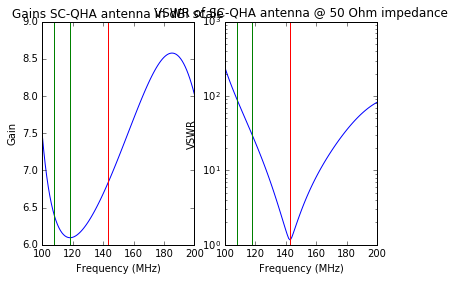

In [14]:
show_report(0.3122, 0.3899, 0.018)

Antenna pattern plotting.  Restart the notebook to reinicialize variables before continue.

In [3]:
%pylab inline
# QHA antenna tunned to GRAVES radar

#nec = sc_quad_helix(0.3115, 0.3831, 0.018)  ## small patch base 1x1m
nec = sc_quad_helix(0.3122, 0.3899, 0.018)

nec.set_frequency(143.05) # TODO: ensure that we don't need to re-generate this!
nec.radiation_pattern(thetas=Range(-180,180, count=180), phis=Range(-180,180,count=180))

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#QHA antenna tunned to VOR beacons

#nec = sc_quad_helix(0.4178, 0.4877, 0.018)
nec = sc_quad_helix(0.4416, 0.4831, 0.018) ## small patch base 1x1m

nec.set_frequency(143.05) # TODO: ensure that we don't need to re-generate this!
nec.radiation_pattern(thetas=Range(-180,180, count=180), phis=Range(-180,180,count=180))

In [4]:
rp = nec.context.get_radiation_pattern(0)
ipt = nec.get_input_parameters(0)
z = ipt.get_impedance()[0]

In [5]:
# Gains are in decibels
gains_db = rp.get_gain() # Is an array of theta,phi -> gain. In this case we only have one phi
thetas = rp.get_theta_angles() * 3.1415 / 180.0
phis = rp.get_phi_angles() * 3.1415 / 180.0

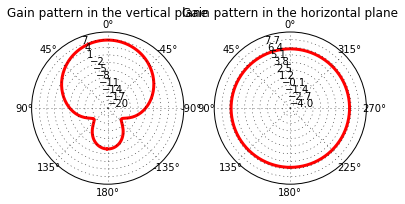

In [6]:
ax = plt.subplot(121, polar=True)
ax.plot(thetas, gains_db[:,90], color='r', linewidth=3)
ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
ax.set_theta_zero_location("N")
ax.set_rlim((-20.0, 10.0)) # TODO: automate. TODO: 4nec2 cheats and makes the lowest points (-999) the same as the lowest non-999 point :)
ax.set_rticks(np.linspace(-20, 10, 10, endpoint=False))
ax.grid(True)
ax.set_title("Gain pattern in the vertical plane", va='bottom')

ax = plt.subplot(122, polar=True)
ax.plot(phis, gains_db[80,:], color='r', linewidth=3)
ax.set_xticks(np.pi/180. * np.linspace(0,  360, 8, endpoint=False))
ax.set_theta_zero_location("N")
ax.set_rlim((-4, 9.0)) # TODO: automate. TODO: 4nec2 cheats and makes the lowest points (-999) the same as the lowest non-999 point :)
ax.set_rticks(np.linspace(-4, 9, 10, endpoint=False))
ax.grid(True)

ax.set_title("Gain pattern in the horizontal plane", va='bottom')
plt.show()